# Base Imports

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import tensorflow_hub as hub
import spacy
import matplotlib.pyplot as plt

In [36]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history, metrics = ['accuracy', 'F1']):
  plt.figure(figsize=(14, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.history[metric], color=colors[0], label='train')
    plt.plot(history.history['val_'+metric],
             color=colors[0], linestyle="--", label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Load Data

In [37]:
TRAIN_SIZE = 0.85
PATH = 'data/'

#"Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"
classes = ["Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]
data_train = pd.read_csv(PATH+'tweets_train.csv')

train_data = data_train.sample(frac=1).reset_index(drop=True)
train_data, val_data = train_data.iloc[:int(TRAIN_SIZE*len(train_data)), :], train_data.iloc[int(TRAIN_SIZE*len(train_data)):, :]

print(train_data.shape)
print(val_data.shape)

(1917, 10)
(339, 10)


# Preprocess Data

## Nivel considerado odio

In [38]:
NIVEL_PARA_ODIO = 3

if NIVEL_PARA_ODIO == 3:
    # Considerar que un dato pertenece solo si las 3 personas pusieron que pertenece
    train_data['Odio'] = np.where(train_data['Odio'] == 3, 1, 0)
    val_data['Odio'] = np.where(val_data['Odio'] == 3, 1, 0)
    train_data['Mujeres'] = np.where(train_data['Mujeres'] == 3, 1, 0)
    val_data['Mujeres'] = np.where(val_data['Mujeres'] == 3, 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where(train_data['Comunidad LGBTQ+'] == 3, 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where(val_data['Comunidad LGBTQ+'] == 3, 1, 0)
    train_data['Comunidades Migrantes'] = np.where(train_data['Comunidades Migrantes'] == 3, 1, 0)
    val_data['Comunidades Migrantes'] = np.where(val_data['Comunidades Migrantes'] == 3, 1, 0)
    train_data['Pueblos Originarios'] = np.where(train_data['Pueblos Originarios'] == 3, 1, 0)
    val_data['Pueblos Originarios'] = np.where(val_data['Pueblos Originarios'] == 3, 1, 0)   
elif NIVEL_PARA_ODIO == 2:
    train_data['Odio'] = np.where((train_data['Odio'] == 3) | (train_data['Odio'] == 2), 1, 0)
    val_data['Odio'] = np.where((val_data['Odio'] == 3) | (val_data['Odio'] == 2), 1, 0)
    train_data['Mujeres'] = np.where((train_data['Mujeres'] == 3) | (train_data['Mujeres'] == 2), 1, 0)
    val_data['Mujeres'] = np.where((val_data['Mujeres'] == 3) | (val_data['Mujeres'] == 2), 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where((train_data['Comunidad LGBTQ+'] == 3) | (train_data['Comunidad LGBTQ+'] == 2), 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where((val_data['Comunidad LGBTQ+'] == 3) | (val_data['Comunidad LGBTQ+'] == 2), 1, 0)
    train_data['Comunidades Migrantes'] = np.where((train_data['Comunidades Migrantes'] == 3) | (train_data['Comunidades Migrantes'] == 2), 1, 0)
    val_data['Comunidades Migrantes'] = np.where((val_data['Comunidades Migrantes'] == 3) | (val_data['Comunidades Migrantes'] == 2), 1, 0)
    train_data['Pueblos Originarios'] = np.where((train_data['Pueblos Originarios'] == 3) | (train_data['Pueblos Originarios'] == 2), 1, 0)
    val_data['Pueblos Originarios'] = np.where((val_data['Pueblos Originarios'] == 3) | (val_data['Pueblos Originarios'] == 2), 1, 0)

## Cleaning

In [39]:
import unidecode

stemmer = SnowballStemmer("spanish")
nlp = spacy.load("es_core_news_lg")
stop_words = stopwords.words("spanish")

def clean_text(text, len_words):
    TEXT_CLEANING_RE = "@\S+" # separado porque solo agarraba la primera etiqueta
    TEXT_CLEANING_RE2 = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
    TEXT_CLEANING_RE_EXTRA = "[^\w\s]"
    if len_words == 1:
        text = re.sub(r'\b\w{1}\b', '', str(text).lower()).strip()
    elif len_words == 2:
        text = re.sub(r'\b\w{1,2}\b', '', str(text).lower()).strip()
    elif len_words == 3:
        text = re.sub(r'\b\w{1,3}\b', '', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE2, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE_EXTRA, ' ', str(text).lower()).strip()
    return text

def preprocess(text,cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=1):
    text = unidecode.unidecode(text)
    if cleaning:
        text = clean_text(text, len_words)
    tokens = []
    for token in text.split():
        if (not stopwords) or (stopwords and (token not in stop_words)):
            if stemming:
                tokens.append(stemmer.stem(token))
            elif lemmatizer:
                doc = nlp(token)
                tokens.append(unidecode.unidecode(doc[0].lemma_))
            else:
                tokens.append(token)    
    text2 = " ".join(tokens)
    if cleaning:
        text2 = clean_text(text2, len_words)
    return text2

## Pruebas de preprocesado

In [40]:
import random

tweet = train_data['text'][random.randint(0, len(train_data))]
#tweet = "@jalessandri @RicardoVenegas7 @hola Estos wueones extranjero haitianos,peruanos, venezolanos y los más ladrones .cubanos .vinieron a echar el país,,,toda está gente vende en las calles y puras cochinadas como vendiendo almuerzo pobladas en la catedral fuera de este país por eso boto RECHAZO....."

print(tweet,"\n")  
print("Sin stopwords:",preprocess(tweet, stopwords=False))
print("Con stemming:",preprocess(tweet, cleaning=True, stopwords=False, stemming=True))
print("Con lematizacion:",preprocess(tweet, cleaning=True, stopwords=False, stemming=False, lemmatizer=True, len_words=1))

Los/as pro vida y feminazis https://t.co/AJX57cKbeZ 

Sin stopwords: los as pro vida feminazis
Con stemming: los as pro vid feminazis
Con lematizacion: el as pro vida feminazi


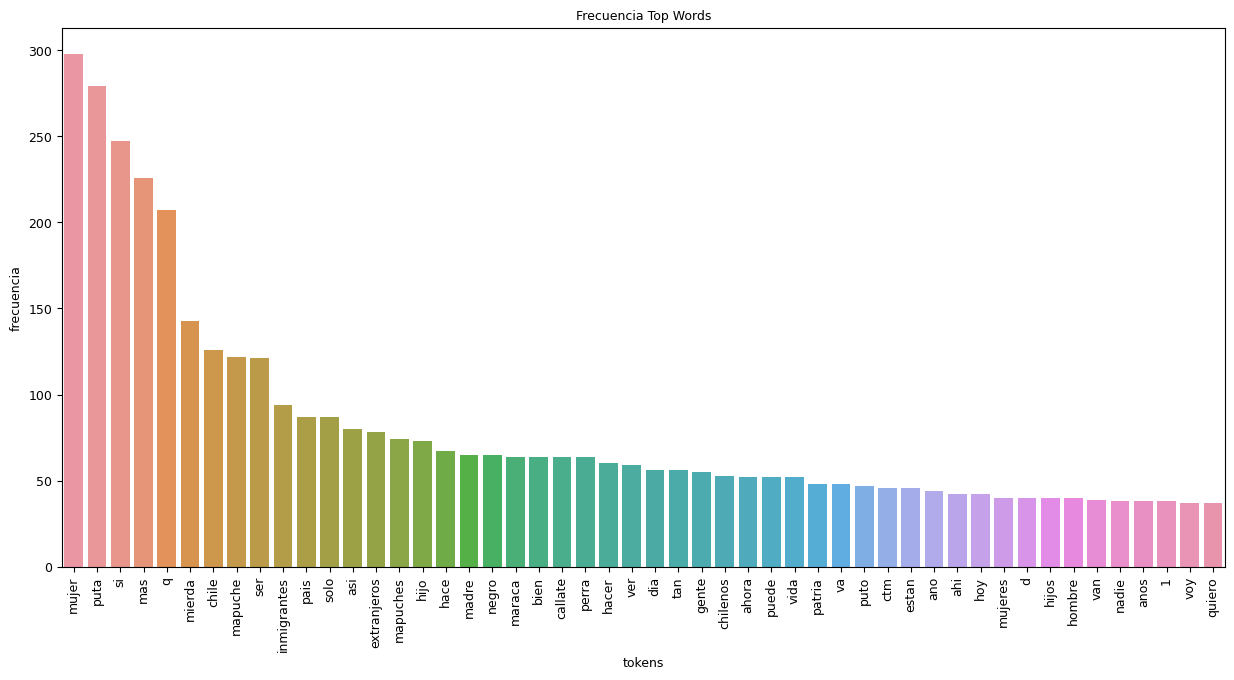

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

n_top_words = 50

tweets= [preprocess(tweet, cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=0).split() for tweet in train_data['text'].values]

top_words = Counter([item for sublist in [tweet for tweet in tweets] for item in sublist]).most_common(n_top_words)

fig, ax = plt.subplots(figsize=(15,7),nrows=1)
ax.set_title('Frecuencia Top Words',fontsize=9)
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
ax.set_xlabel("tokens",fontsize=9)
ax.set_ylabel("frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=90)
plt.show()

# Definición de modelo y datos a usar

In [42]:
CLEANING = True
STOPWORDS = True
STEMMING = False
LEMMATIZER = False
LEN_WORDS = 1

train_tweets = [preprocess(tweet, cleaning=CLEANING, stopwords=STOPWORDS, stemming=STEMMING, lemmatizer=LEMMATIZER, len_words=LEN_WORDS) for tweet in train_data['text'].values]
val_tweets = [preprocess(tweet) for tweet in val_data['text'].values]
y_train_categorias = train_data[classes].values
y_val_categorias = val_data[classes].values

print(y_train_categorias.shape)
print(y_val_categorias.shape)

(1917, 5)
(339, 5)


In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_max_words = 5000

Seq_tokenizer = Tokenizer(num_words=n_max_words)
Seq_tokenizer.fit_on_texts(train_tweets)

train_sequences = Seq_tokenizer.texts_to_sequences(train_tweets)
val_sequences = Seq_tokenizer.texts_to_sequences(val_tweets)

max_text_length = 50
train_sequences = pad_sequences(train_sequences, maxlen=max_text_length)
val_sequences = pad_sequences(val_sequences, maxlen=max_text_length)

In [44]:
import tensorflow_addons as tfa
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro', num_classes=len(classes)),
      tf.metrics.Recall(name='recall')
]

In [45]:
wcounts = list(Seq_tokenizer.word_counts.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
top_words = wcounts[:n_max_words]
top_words = [w[0] for w in top_words]
print(top_words)

['mujer', 'puta', 'si', 'mas', 'mierda', 'chile', 'mapuche', 'ser', 'inmigrantes', 'pais', 'solo', 'asi', 'extranjeros', 'mapuches', 'hijo', 'hace', 'madre', 'negro', 'maraca', 'bien', 'callate', 'perra', 'hacer', 'ver', 'dia', 'tan', 'gente', 'chilenos', 'ahora', 'puede', 'vida', 'patria', 'va', 'puto', 'ctm', 'estan', 'ano', 'ahi', 'hoy', 'mujeres', 'hijos', 'hombre', 'van', 'nadie', 'anos', 'voy', 'quiero', 'menos', 'da', 'cara', 'mejor', 'toda', 'qla', 'tener', 'gobierno', 'quieren', 'casa', 'mal', 'vez', 'venezolanos', 'gay', 'siempre', 'personas', 'dice', 'peor', 'verdad', 'cada', 'etc', 'decir', 'hija', 'trabajo', 'dios', 'creo', 'mundo', 'delincuentes', 'nunca', 'pueblo', 'pasa', 'culia', 'indio', 'persona', 'hecho', 'ir', 'buena', 'feliz', 'nuevo', 'aqui', 'bueno', 'poder', 'cuenta', 'pa', 'vos', 'falta', 'anda', 'quiere', 'vieja', 'parte', 'feminista', 're', 'indigena', 'ustedes', 'culiao', 'venezolano', 'culiaos', 'hacen', 'cosas', 'trans', 'gracias', 'asco', 'cosa', 'wea', 

In [46]:
# count the class distribution
class_counts = train_data[classes].sum(axis=0)
print(class_counts)

Odio                     540
Mujeres                  164
Comunidad LGBTQ+          86
Comunidades Migrantes    231
Pueblos Originarios      189
dtype: int64


## Embeddings pre-hechos

In [47]:
USE_PRETRAINED = True

if USE_PRETRAINED:
    

    emb_dict = {}

    glove_file = 'embeddings.txt'
    glove_dir = ''#path to the file

    glove = open(glove_dir+glove_file)
    primero = True
    for line in glove:
        if primero:
            emd_dim = int(line.split()[1])
            primero = False
        else:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            emb_dict[word] = vector

    glove.close()

In [48]:
if USE_PRETRAINED:
  n_max_words_vis = 5000
  wcounts = list(Seq_tokenizer.word_counts.items())
  wcounts.sort(key=lambda x: x[1], reverse=True)
  top_words = wcounts[:n_max_words_vis]
  top_words = [w[0] for w in top_words]
  reverse_word_index = dict([(value, key) for (key, value) in Seq_tokenizer.word_index.items()])

  top_words[:10]

  word_index = Seq_tokenizer.word_index
  emb_matrix = np.zeros((n_max_words, emd_dim))

  not_found = 0
  for word in top_words[:-1]:
    vect = emb_dict.get(word)
    idx_word = word_index[word]
    if vect is not None:
      emb_matrix[idx_word] = vect
    else:
      emb_matrix[idx_word] = np.random.normal(0,0.1,emd_dim) # (La estrategia es asignar un vector aleatorio)
      not_found+=1

  print("Palabras del Diccionario no Encontradas en Glove ", not_found, " DE ", n_max_words)

Palabras del Diccionario no Encontradas en Glove  2223  DE  5000


# Entrenamiento

In [49]:
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, SpatialDropout1D

emd_dim = 100

def RNN_warm(pre_trained_we,max_text_length,fine_tune_we=False):
  input_sequence = keras.Input(shape=(max_text_length),dtype="int64")
  embedded_sequence = Embedding(pre_trained_we.shape[0], pre_trained_we.shape[1])(input_sequence)
  embedded_sequence = SpatialDropout1D(0.25)(embedded_sequence)
  recurrent = LSTM(50,return_sequences=False)(embedded_sequence)
  recurrent = LSTM(50,return_sequences=True)(embedded_sequence)
  recurrent = SpatialDropout1D(0.25)(recurrent)
  recurrent = LSTM(50,return_sequences=False)(recurrent)
  recurrent = Dense(100, activation='relu')(recurrent)
  sentiment = Dense(len(classes),activation="sigmoid")(recurrent)
  modelo_recurrente = keras.Model(input_sequence, sentiment)
  modelo_recurrente.layers[1].set_weights([pre_trained_we])
  modelo_recurrente.layers[1].trainable = fine_tune_we
  return modelo_recurrente

def RNN():
  input_sequence = keras.Input(shape=(max_text_length),dtype="int64")
  embedded_sequence = Embedding(n_max_words, emd_dim)(input_sequence)
  embedded_sequence = SpatialDropout1D(0.25)(embedded_sequence)
  #recurrent = LSTM(25,return_sequences=False)(embedded_sequence)
  recurrent = LSTM(25,return_sequences=True)(embedded_sequence)
  recurrent = SpatialDropout1D(0.25)(recurrent)
  recurrent = LSTM(25,return_sequences=False)(recurrent)
  recurrent = Dense(25, activation='relu')(recurrent)
  sentiment = Dense(len(classes),activation="sigmoid")(recurrent)
  modelo_recurrente = keras.Model(input_sequence, sentiment)
  return modelo_recurrente

In [50]:
from tensorflow.keras.optimizers import SGD, Adam

if USE_PRETRAINED:
    modelo_recurrente = RNN_warm(emb_matrix,max_text_length,fine_tune_we=False)
else:
    modelo_recurrente = RNN()

modelo_recurrente.summary()
opt = Adam()
modelo_recurrente.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 100)           500000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 50, 50)            30200     
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 50)                2020

In [51]:
metrica_monitoreada = 'val_F1'

print("metrica monitoreada", metrica_monitoreada)

checkpoint_path = 'LSTM_based_checkpoints/LSTM.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor=metrica_monitoreada,mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor=metrica_monitoreada, patience=7, restore_best_weights=True, mode='max')
history_modelo_recurrente = modelo_recurrente.fit(train_sequences, y_train_categorias, epochs=80, batch_size=4, validation_data=(val_sequences, y_val_categorias), callbacks=[es])

metrica monitoreada val_F1
Epoch 1/80


480/480 [==============================] - 15s 24ms/step - loss: 0.3675 - accuracy: 0.8719 - F1: 0.1066 - recall: 0.0083 - val_loss: 0.3244 - val_accuracy: 0.8903 - val_F1: 0.0779 - val_recall: 0.0000e+00
Epoch 2/80
480/480 [==============================] - 11s 22ms/step - loss: 0.3506 - accuracy: 0.8734 - F1: 0.0941 - recall: 0.0017 - val_loss: 0.3309 - val_accuracy: 0.8903 - val_F1: 0.0779 - val_recall: 0.0000e+00
Epoch 3/80
480/480 [==============================] - 11s 22ms/step - loss: 0.3473 - accuracy: 0.8744 - F1: 0.0879 - recall: 0.0231 - val_loss: 0.3229 - val_accuracy: 0.8903 - val_F1: 0.0779 - val_recall: 0.0000e+00
Epoch 4/80
480/480 [==============================] - 11s 22ms/step - loss: 0.3471 - accuracy: 0.8738 - F1: 0.0879 - recall: 8.2645e-04 - val_loss: 0.3246 - val_accuracy: 0.8903 - val_F1: 0.0779 - val_recall: 0.0000e+00
Epoch 5/80
480/480 [==============================] - 11s 22ms/step - loss: 0.3471 - accuracy: 0.8738 - F1: 0.0879 - recall: 0.0000e+00 - val_l

In [40]:
modelo_recurrente.save('LSTM_model/LSTM_'+str(len(classes))+'class_F1-{:.4f}.h5'.format((history_modelo_recurrente.history['val_F1'][-1])))

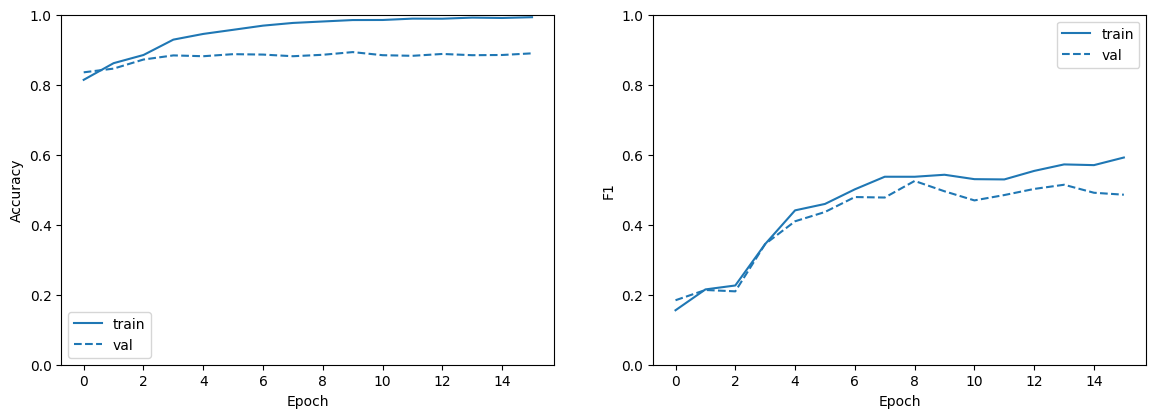

In [37]:
plot_metrics(history_modelo_recurrente)

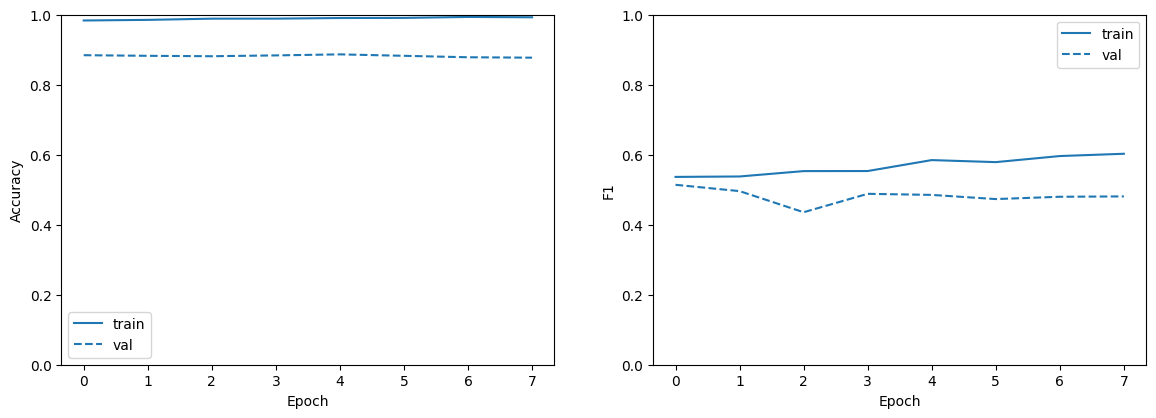

In [39]:
plot_metrics(history_modelo_recurrente)

# Predicciones

In [77]:
test_data = pd.read_csv('data/public_test.csv')
test_tweets = [preprocess(tweet) for tweet in test_data['text'].values]
bert_input_test = prepare_input_for_bert(test_tweets,bert_tokenizer,max_seq_len)

y_pred_categorias = bert_model.predict(bert_input_test)
for row in y_pred_categorias:
    for i in range(len(classes)):
        if row[i] > 0.5:
            row[i] = 1
        else:
            row[i] = 0
y_pred_categorias = pd.DataFrame(y_pred_categorias, columns=[classes])
y_pred_categorias.to_csv('predicciones.csv', index=False)
y_pred_categorias

72/72 [==============================] - 4s 45ms/step


,Odio,Mujeres,Comunidad LGBTQ+,Comunidades Migrantes,Pueblos Originarios
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2286,1.0,0.0,0.0,1.0,0.0
2287,0.0,0.0,0.0,0.0,0.0
2288,0.0,0.0,0.0,0.0,0.0
2289,1.0,0.0,1.0,0.0,0.0


In [78]:
#!shutdown -s -t 60